In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


# # Data Loading and Upload from Windows System


In [8]:
from google.colab import files

# CSV dosyasını yükle (masaüstünden seç)
uploaded = files.upload()

Saving linux_auth_logs_labeled.csv to linux_auth_logs_labeled.csv


# # 1. Load and Explore Data


In [11]:


# Dosya adı
csv_name = "linux_auth_logs_labeled.csv"

# DataFrame'e yükle
df = pd.read_csv(csv_name)

# Dataset overview
print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"Dataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nFirst 5 rows:")
print(df.head())


DATASET OVERVIEW
Dataset Shape: 500000 rows, 11 columns

First 5 rows:
                    timestamp        source_ip         server    username  \
0  2023-03-01T02:34:21.401236    195.241.151.7   proxy-mow-01      achang   
1  2024-08-14T04:53:31.834545   164.218.94.112     srv-ldn-02    www-data   
2  2026-11-13T23:42:42.559210    45.250.247.54  backup-prk-01    www-data   
3  2025-06-21T19:38:58.716613    114.89.244.50     srv-tok-03  juancampos   
4  2024-03-28T19:34:14.984218  186.144.249.195     srv-tok-03       nginx   

  service  attempts   status  port protocol  \
0    sudo         3   Failed    22   TELNET   
1    sudo         4   Failed   443      RDP   
2      su         2   Failed    22   TELNET   
3   login         1  Success    22     SSH2   
4    cron         3   Failed    80      NaN   

                                   comment anomaly_label  
0        User achang failed login via sudo        normal  
1      User www-data failed login via sudo        normal  
2     

In [12]:
# Display basic information
print("\n" + "="*80)
print("COLUMN INFORMATION")
print("="*80)
df.info()



COLUMN INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   timestamp      500000 non-null  object
 1   source_ip      500000 non-null  object
 2   server         500000 non-null  object
 3   username       500000 non-null  object
 4   service        500000 non-null  object
 5   attempts       500000 non-null  int64 
 6   status         500000 non-null  object
 7   port           500000 non-null  int64 
 8   protocol       375404 non-null  object
 9   comment        500000 non-null  object
 10  anomaly_label  500000 non-null  object
dtypes: int64(2), object(9)
memory usage: 42.0+ MB


In [13]:
# Display statistical summary
print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)
print(df.describe(include='all'))



STATISTICAL SUMMARY
                         timestamp       source_ip        server username  \
count                       500000          500000        500000   500000   
unique                      500000          499965             9    95426   
top     2025-02-11T06:36:21.009671  210.142.178.40  proxy-mow-01     root   
freq                             1               2         56679    62358   
mean                           NaN             NaN           NaN      NaN   
std                            NaN             NaN           NaN      NaN   
min                            NaN             NaN           NaN      NaN   
25%                            NaN             NaN           NaN      NaN   
50%                            NaN             NaN           NaN      NaN   
75%                            NaN             NaN           NaN      NaN   
max                            NaN             NaN           NaN      NaN   

       service       attempts  status           port p

# # 2. Check for Missing Data


In [14]:
# Check missing values
print("\n" + "="*80)
print("MISSING DATA ANALYSIS")
print("="*80)

missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

print("\nColumns with Missing Values:")
if len(missing_data) > 0:
    print(missing_data)
else:
    print("No missing values found!")



MISSING DATA ANALYSIS

Columns with Missing Values:
            Column  Missing_Count  Missing_Percentage
protocol  protocol         124596             24.9192


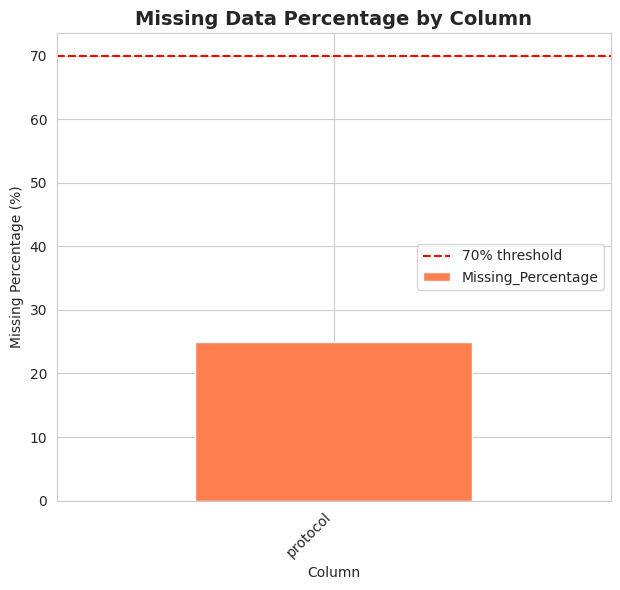

In [15]:
# Visualize missing data
plt.figure(figsize=(12, 6))
if len(missing_data) > 0:
    plt.subplot(1, 2, 1)
    missing_data.plot(x='Column', y='Missing_Percentage', kind='bar', ax=plt.gca(), legend=False, color='coral')
    plt.title('Missing Data Percentage by Column', fontsize=14, fontweight='bold')
    plt.xlabel('Column')
    plt.ylabel('Missing Percentage (%)')
    plt.xticks(rotation=45, ha='right')
    plt.axhline(y=70, color='r', linestyle='--', label='70% threshold')
    plt.legend()
    plt.tight_layout()
else:
    plt.text(0.5, 0.5, 'No Missing Data Found!',
             horizontalalignment='center', verticalalignment='center',
             fontsize=20, fontweight='bold')
    plt.axis('off')

plt.show()


# # 3. Handle Missing Data


In [16]:
# Handle missing data based on threshold
print("\n" + "="*80)
print("HANDLING MISSING DATA")
print("="*80)

df_cleaned = df.copy()
columns_to_drop = []
columns_to_fill = []

for col in df_cleaned.columns:
    missing_pct = (df_cleaned[col].isnull().sum() / len(df_cleaned)) * 100

    if missing_pct > 70:
        columns_to_drop.append(col)
        print(f"Dropping column '{col}' - Missing: {missing_pct:.2f}%")
    elif missing_pct > 0:
        columns_to_fill.append(col)
        # Fill numeric columns with median
        if df_cleaned[col].dtype in ['int64', 'float64']:
            median_value = df_cleaned[col].median()
            df_cleaned[col].fillna(median_value, inplace=True)
            print(f"Filling column '{col}' with median ({median_value}) - Missing: {missing_pct:.2f}%")
        else:
            # Fill categorical columns with mode
            mode_value = df_cleaned[col].mode()[0] if not df_cleaned[col].mode().empty else 'Unknown'
            df_cleaned[col].fillna(mode_value, inplace=True)
            print(f"Filling column '{col}' with mode ('{mode_value}') - Missing: {missing_pct:.2f}%")

# Drop columns with >70% missing data
if columns_to_drop:
    df_cleaned.drop(columns=columns_to_drop, inplace=True)
    print(f"\n✓ Dropped {len(columns_to_drop)} column(s)")

print(f"\n✓ Dataset shape after handling missing data: {df_cleaned.shape}")



HANDLING MISSING DATA
Filling column 'protocol' with mode ('RDP') - Missing: 24.92%

✓ Dataset shape after handling missing data: (500000, 11)


# # 4. Remove Duplicate Rows


In [17]:
# Check and remove duplicates
print("\n" + "="*80)
print("HANDLING DUPLICATE ROWS")
print("="*80)

initial_rows = len(df_cleaned)
duplicates_count = df_cleaned.duplicated().sum()

print(f"Number of duplicate rows found: {duplicates_count}")

if duplicates_count > 0:
    df_cleaned = df_cleaned.drop_duplicates()
    print(f"✓ Removed {duplicates_count} duplicate rows")
    print(f"✓ Rows remaining: {len(df_cleaned)} (from {initial_rows})")
else:
    print("✓ No duplicate rows found")



HANDLING DUPLICATE ROWS
Number of duplicate rows found: 0
✓ No duplicate rows found


# # 5. Data Visualization


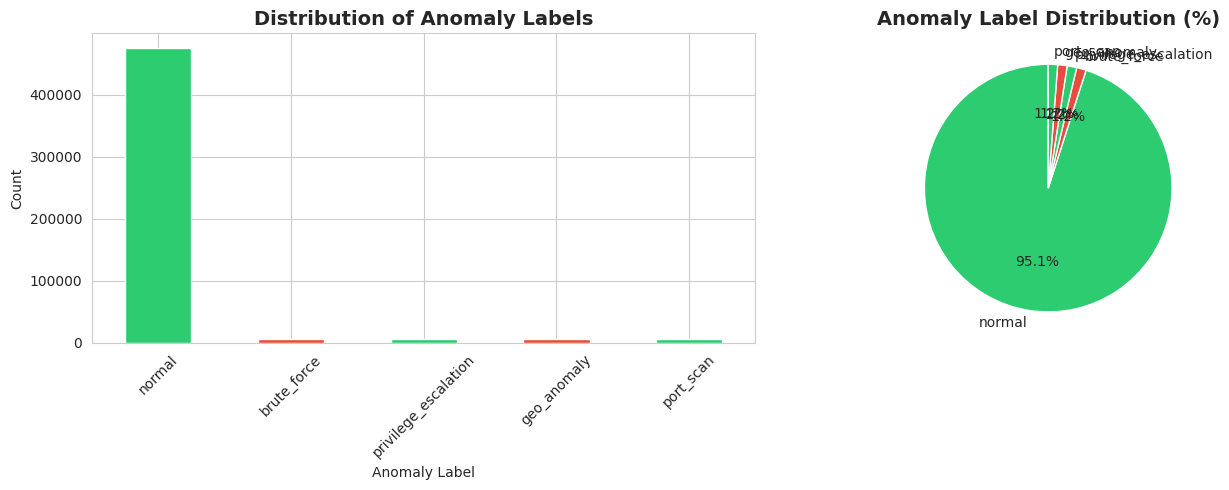

In [18]:
# Plot class distribution (if anomaly_label exists)
if 'anomaly_label' in df_cleaned.columns:
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    anomaly_counts = df_cleaned['anomaly_label'].value_counts()
    anomaly_counts.plot(kind='bar', color=['#2ecc71', '#e74c3c'])
    plt.title('Distribution of Anomaly Labels', fontsize=14, fontweight='bold')
    plt.xlabel('Anomaly Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    plt.pie(anomaly_counts, labels=anomaly_counts.index, autopct='%1.1f%%',
            colors=['#2ecc71', '#e74c3c'], startangle=90)
    plt.title('Anomaly Label Distribution (%)', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()


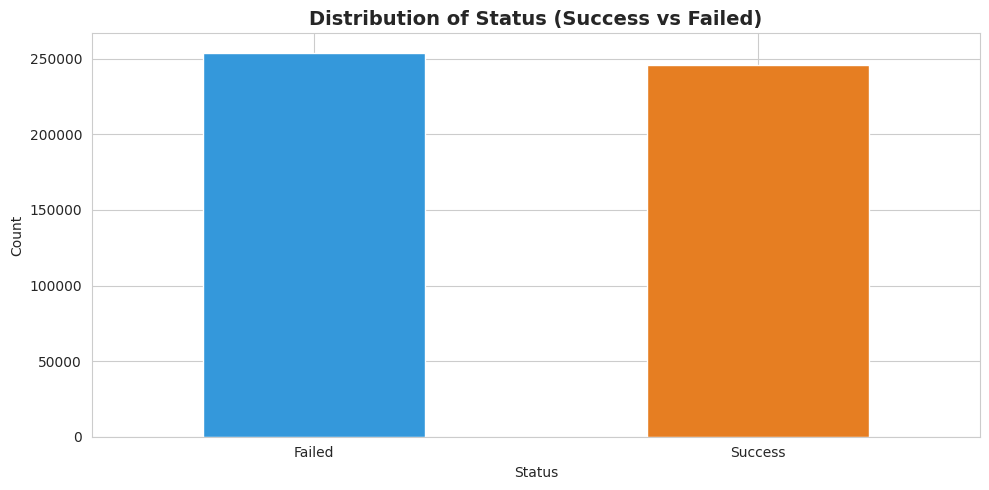

In [19]:
# Plot status distribution
if 'status' in df_cleaned.columns:
    plt.figure(figsize=(10, 5))
    status_counts = df_cleaned['status'].value_counts()
    status_counts.plot(kind='bar', color=['#3498db', '#e67e22'])
    plt.title('Distribution of Status (Success vs Failed)', fontsize=14, fontweight='bold')
    plt.xlabel('Status')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


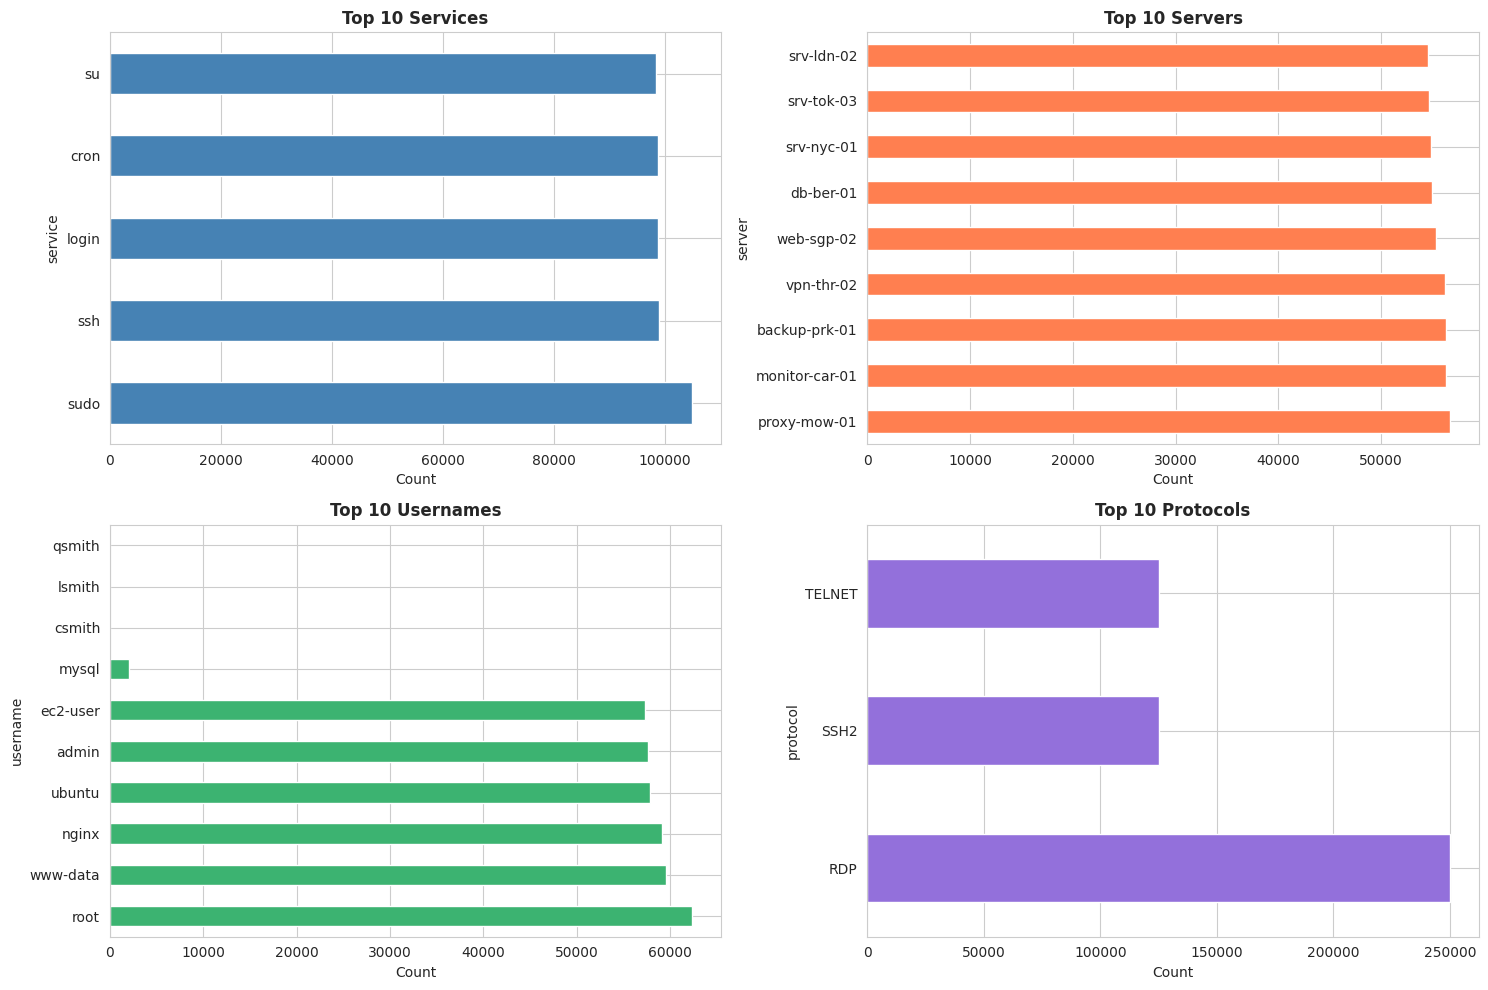

In [20]:
# Plot top services and servers
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

if 'service' in df_cleaned.columns:
    df_cleaned['service'].value_counts().head(10).plot(kind='barh', ax=axes[0, 0], color='steelblue')
    axes[0, 0].set_title('Top 10 Services', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Count')

if 'server' in df_cleaned.columns:
    df_cleaned['server'].value_counts().head(10).plot(kind='barh', ax=axes[0, 1], color='coral')
    axes[0, 1].set_title('Top 10 Servers', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Count')

if 'username' in df_cleaned.columns:
    df_cleaned['username'].value_counts().head(10).plot(kind='barh', ax=axes[1, 0], color='mediumseagreen')
    axes[1, 0].set_title('Top 10 Usernames', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Count')

if 'protocol' in df_cleaned.columns:
    df_cleaned['protocol'].value_counts().head(10).plot(kind='barh', ax=axes[1, 1], color='mediumpurple')
    axes[1, 1].set_title('Top 10 Protocols', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Count')

plt.tight_layout()
plt.show()


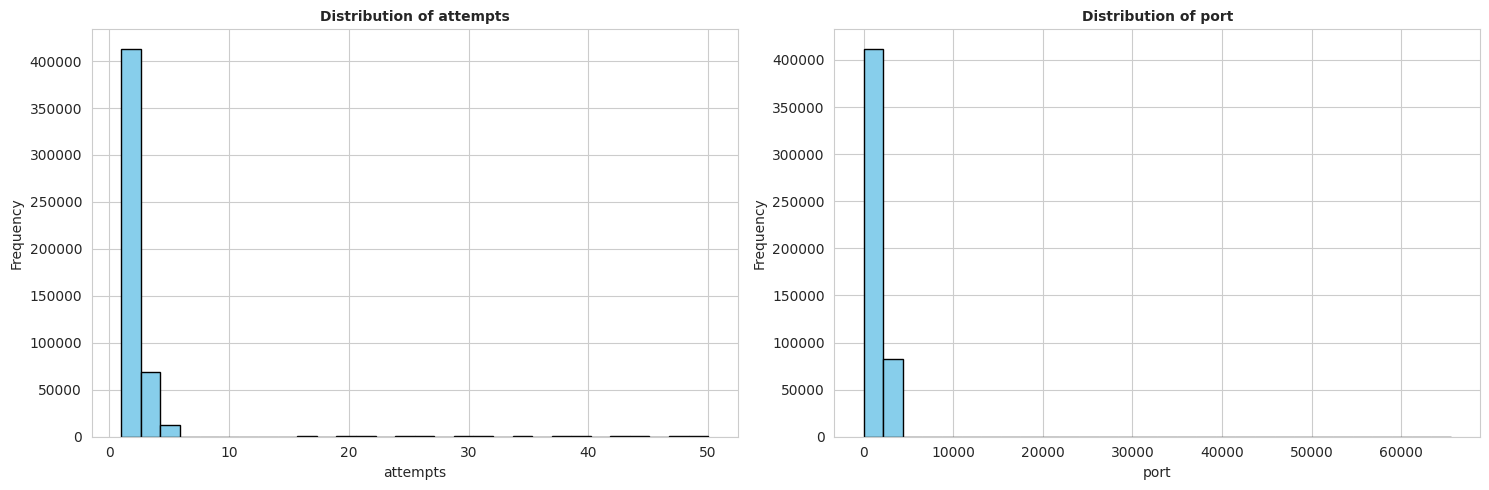

In [22]:
# Plot numerical features distribution
numerical_cols = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
if 'anomaly_label' in numerical_cols:
    numerical_cols.remove('anomaly_label')

if len(numerical_cols) > 0:
    n_cols = min(3, len(numerical_cols))
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]

    for idx, col in enumerate(numerical_cols):
        axes[idx].hist(df_cleaned[col].dropna(), bins=30, color='skyblue', edgecolor='black')
        axes[idx].set_title(f'Distribution of {col}', fontsize=10, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')

    # Hide extra subplots
    for idx in range(len(numerical_cols), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()


# # 6. Split Data into Train, Test, and Validation Sets


In [23]:
print("\n" + "="*80)
print("SPLITTING DATA")
print("="*80)

# Split: 70% train, 20% test, 10% validation
# First split: 70% train, 30% temp (test + validation)
train_data, temp_data = train_test_split(df_cleaned, test_size=0.30, random_state=42,
                                         stratify=df_cleaned['anomaly_label'] if 'anomaly_label' in df_cleaned.columns else None)

# Second split: Split temp into 66.67% test (20% of total) and 33.33% validation (10% of total)
test_data, val_data = train_test_split(temp_data, test_size=0.3333, random_state=42,
                                       stratify=temp_data['anomaly_label'] if 'anomaly_label' in temp_data.columns else None)

print(f"Training set: {len(train_data)} rows ({len(train_data)/len(df_cleaned)*100:.1f}%)")
print(f"Test set: {len(test_data)} rows ({len(test_data)/len(df_cleaned)*100:.1f}%)")
print(f"Validation set: {len(val_data)} rows ({len(val_data)/len(df_cleaned)*100:.1f}%)")
print(f"\nTotal: {len(train_data) + len(test_data) + len(val_data)} rows")



SPLITTING DATA
Training set: 350000 rows (70.0%)
Test set: 100005 rows (20.0%)
Validation set: 49995 rows (10.0%)

Total: 500000 rows


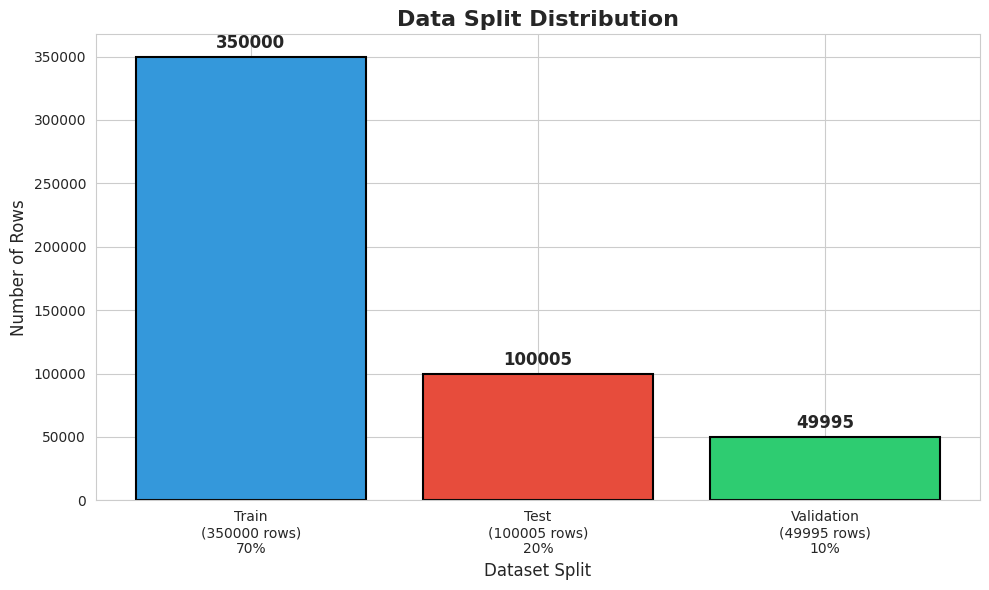

In [24]:
# Visualize the split
plt.figure(figsize=(10, 6))
split_sizes = [len(train_data), len(test_data), len(val_data)]
split_labels = [f'Train\n({len(train_data)} rows)\n70%',
                f'Test\n({len(test_data)} rows)\n20%',
                f'Validation\n({len(val_data)} rows)\n10%']
colors = ['#3498db', '#e74c3c', '#2ecc71']

plt.bar(split_labels, split_sizes, color=colors, edgecolor='black', linewidth=1.5)
plt.title('Data Split Distribution', fontsize=16, fontweight='bold')
plt.ylabel('Number of Rows', fontsize=12)
plt.xlabel('Dataset Split', fontsize=12)

# Add value labels on bars
for i, (label, size) in enumerate(zip(split_labels, split_sizes)):
    plt.text(i, size + max(split_sizes)*0.01, str(size),
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


# # 7. Normalization (Optional - for numerical features)



NORMALIZATION
Numerical features to normalize: ['attempts', 'port']
✓ Normalization completed using StandardScaler
✓ Mean ≈ 0, Std ≈ 1 for numerical features


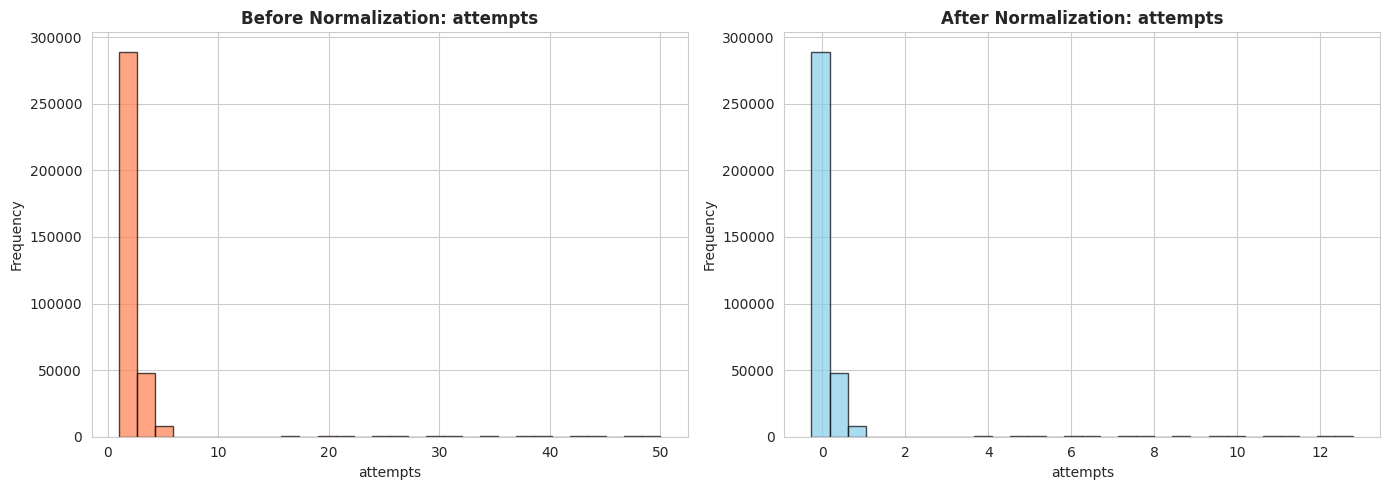

In [25]:
print("\n" + "="*80)
print("NORMALIZATION")
print("="*80)

# Identify numerical columns for normalization (excluding target if present)
numerical_features = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()

# Remove target column if exists
if 'anomaly_label' in numerical_features:
    numerical_features.remove('anomaly_label')

if len(numerical_features) > 0:
    print(f"Numerical features to normalize: {numerical_features}")

    # Initialize scaler
    scaler = StandardScaler()

    # Fit scaler on training data only
    train_data_normalized = train_data.copy()
    test_data_normalized = test_data.copy()
    val_data_normalized = val_data.copy()

    # Fit on train and transform all sets
    train_data_normalized[numerical_features] = scaler.fit_transform(train_data[numerical_features])
    test_data_normalized[numerical_features] = scaler.transform(test_data[numerical_features])
    val_data_normalized[numerical_features] = scaler.transform(val_data[numerical_features])

    print("✓ Normalization completed using StandardScaler")
    print(f"✓ Mean ≈ 0, Std ≈ 1 for numerical features")

    # Show before/after comparison for first numerical feature
    if len(numerical_features) > 0:
        feature = numerical_features[0]
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        axes[0].hist(train_data[feature], bins=30, color='coral', edgecolor='black', alpha=0.7)
        axes[0].set_title(f'Before Normalization: {feature}', fontsize=12, fontweight='bold')
        axes[0].set_xlabel(feature)
        axes[0].set_ylabel('Frequency')

        axes[1].hist(train_data_normalized[feature], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        axes[1].set_title(f'After Normalization: {feature}', fontsize=12, fontweight='bold')
        axes[1].set_xlabel(feature)
        axes[1].set_ylabel('Frequency')

        plt.tight_layout()
        plt.show()
else:
    print("No numerical features found for normalization")
    train_data_normalized = train_data.copy()
    test_data_normalized = test_data.copy()
    val_data_normalized = val_data.copy()


# # 8. Save Processed Data to CSV Files


In [26]:
print("\n" + "="*80)
print("SAVING PROCESSED DATA")
print("="*80)

# Save non-normalized versions
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)
val_data.to_csv('validation_data.csv', index=False)

print("✓ Saved: train_data.csv")
print("✓ Saved: test_data.csv")
print("✓ Saved: validation_data.csv")

# Save normalized versions
if len(numerical_features) > 0:
    train_data_normalized.to_csv('train_data_normalized.csv', index=False)
    test_data_normalized.to_csv('test_data_normalized.csv', index=False)
    val_data_normalized.to_csv('validation_data_normalized.csv', index=False)

    print("\n✓ Saved: train_data_normalized.csv")
    print("✓ Saved: test_data_normalized.csv")
    print("✓ Saved: validation_data_normalized.csv")

# Save cleaned full dataset
df_cleaned.to_csv('cleaned_full_data.csv', index=False)
print("\n✓ Saved: cleaned_full_data.csv")

print("\n" + "="*80)
print("DATA PREPROCESSING COMPLETE!")
print("="*80)



SAVING PROCESSED DATA
✓ Saved: train_data.csv
✓ Saved: test_data.csv
✓ Saved: validation_data.csv

✓ Saved: train_data_normalized.csv
✓ Saved: test_data_normalized.csv
✓ Saved: validation_data_normalized.csv

✓ Saved: cleaned_full_data.csv

DATA PREPROCESSING COMPLETE!


# # Summary Report


In [27]:
print("\n" + "="*80)
print("PREPROCESSING SUMMARY REPORT")
print("="*80)

print("\n📊 Original Dataset:")
print(f"   - Shape: {df.shape}")
print(f"   - Columns: {df.shape[1]}")
print(f"   - Rows: {df.shape[0]}")

print("\n🧹 Data Cleaning:")
print(f"   - Columns dropped (>70% missing): {len(columns_to_drop)}")
print(f"   - Columns filled (missing data): {len(columns_to_fill)}")
print(f"   - Duplicate rows removed: {duplicates_count}")

print("\n📦 Cleaned Dataset:")
print(f"   - Shape: {df_cleaned.shape}")
print(f"   - Columns: {df_cleaned.shape[1]}")
print(f"   - Rows: {df_cleaned.shape[0]}")

print("\n✂️ Data Split:")
print(f"   - Train: {len(train_data)} rows (70%)")
print(f"   - Test: {len(test_data)} rows (20%)")
print(f"   - Validation: {len(val_data)} rows (10%)")

print("\n🔢 Normalization:")
print(f"   - Numerical features normalized: {len(numerical_features)}")
print(f"   - Method: StandardScaler (mean=0, std=1)")

print("\n💾 Files Saved:")
print("   - train_data.csv")
print("   - test_data.csv")
print("   - validation_data.csv")
if len(numerical_features) > 0:
    print("   - train_data_normalized.csv")
    print("   - test_data_normalized.csv")
    print("   - validation_data_normalized.csv")
print("   - cleaned_full_data.csv")

print("\n" + "="*80)
print("✅ ALL TASKS COMPLETED SUCCESSFULLY!")
print("="*80)



PREPROCESSING SUMMARY REPORT

📊 Original Dataset:
   - Shape: (500000, 11)
   - Columns: 11
   - Rows: 500000

🧹 Data Cleaning:
   - Columns dropped (>70% missing): 0
   - Columns filled (missing data): 1
   - Duplicate rows removed: 0

📦 Cleaned Dataset:
   - Shape: (500000, 11)
   - Columns: 11
   - Rows: 500000

✂️ Data Split:
   - Train: 350000 rows (70%)
   - Test: 100005 rows (20%)
   - Validation: 49995 rows (10%)

🔢 Normalization:
   - Numerical features normalized: 2
   - Method: StandardScaler (mean=0, std=1)

💾 Files Saved:
   - train_data.csv
   - test_data.csv
   - validation_data.csv
   - train_data_normalized.csv
   - test_data_normalized.csv
   - validation_data_normalized.csv
   - cleaned_full_data.csv

✅ ALL TASKS COMPLETED SUCCESSFULLY!


# # Continue with Feature Engineering (Original Analysis)
